In [39]:
cd /content/drive/My Drive/Projects/CoronaVirus detection /Features on CXR using Limited Training DataSet/src

/content/drive/My Drive/Projects/CoronaVirus detection /Features on CXR using Limited Training DataSet/src


In [47]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-yklwnow6
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-yklwnow6
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20032 sha256=80ad61dbaf6123e3b83c6e85560f751b3153021bbaad281a759cc0c4453c1edb
  Stored in directory: /tmp/pip-ephem-wheel-cache-39hpc92z/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


#1.0 Testing data generators

In [41]:
import numpy as np
import os
import pandas as pd
from keras.utils import Sequence
import cv2
from skimage.transform import resize
from sklearn.feature_extraction.image import extract_patches_2d
import time
from augmenter import augmenter
from google.colab.patches import cv2_imshow

In [42]:
class AugmentedImageSequence(Sequence):
    def __init__(self, dataset_csv_file, base_dir, batch_size, target_size, augmenter, steps, shuffle_on_epoch_end, random_state):
        self.dataset_df = pd.read_csv(dataset_csv_file)
        self.base_dir = base_dir

        self.batch_size = batch_size
        self.target_size = target_size
        self.augmenter = augmenter
        
        self.shuffle = shuffle_on_epoch_end
        self.random_state = random_state
        
        self.prepare_dataset()

        if steps is None:
            self.steps = int(np.ceil(len(self.x) / float(self.batch_size)))
        else:
            self.steps = int(steps)

    def __bool__(self):
        return True

    def __len__(self):
        return self.steps

    def __getitem__(self, idx): 
        x_batch_files = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        y_batch_files = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]       
        
        batch_x = self.load_x(x_batch_files)
        batch_y = self.load_y(y_batch_files)

        return batch_x, batch_y

    def load_x(self, files):
        pass
    
    def load_y(self, files):
        pass

    def normalize(self, img):
        pass
    
    def prepare_dataset(self):
        pass

    def on_epoch_end(self):
        if self.shuffle:
            self.random_state += 1
            self.prepare_dataset()

class segmentation_gen(AugmentedImageSequence):
    def __init__(self, dataset_csv_file, base_dir, batch_size=16, target_size=(256, 256), augmenter=None, steps=None,
                shuffle_on_epoch_end=True, random_state=1):

        super(segmentation_gen, self).__init__(dataset_csv_file, base_dir, batch_size, target_size, augmenter, steps, shuffle_on_epoch_end, random_state)

    def __set_aug(self):
        self.det_aug = self.augmenter.to_deterministic()

    def load_x(self, files):
        # f[1] -> folder, f[0] -> filename
        file_path = [os.path.join(self.base_dir, f[1], f[0]) for f in files]
        #read
        image_array = [cv2.imread(f, 0) for f in file_path]
        #resize and normalize
        image_array = np.array([self.normalize(resize(img, self.target_size)) for img in image_array])

        #get a deterministic augmenter to do same augmentation on both image and mask
        if(self.augmenter is not None):
            self.__set_aug()
            image_array = np.array(self.det_aug.augment_images(image_array))
        image_array = np.expand_dims(image_array, -1)
        return image_array

    def load_y(self, files):
        file_path = [os.path.join(self.base_dir, f[1], f[0]) for f in files]
        #read
        mask_array = [cv2.imread(f, 0) for f in file_path]
        #resize and thresholding
        mask_array = np.array([resize(img, self.target_size) for img in mask_array])
        
        if(self.augmenter is not None):
            mask_array = np.array(self.det_aug.augment_images(mask_array))
        mask_array = np.expand_dims(mask_array, -1)

        return mask_array

    def normalize(self, img):
        img = np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)) 
        #Histogram equaliztion of the given image
        img = cv2.equalizeHist(img) 
        #Gamma correction with gamma = 0.5
        gamma = 0.5
        table = np.array([(np.float_power(i/255.0, gamma)) * 255 for i in np.arange(0, 256)]).astype("float32")
        img = cv2.LUT(img, table)

        return (img/255.0)
        
    def prepare_dataset(self):
        df = self.dataset_df.sample(frac=1.0, random_state=self.random_state)
        self.x = np.concatenate([df['filename'].values.reshape(-1, 1), df['image_folder'].values.reshape(-1, 1)], axis = -1)
        
        self.y = np.concatenate([df['filename'].values.reshape(-1, 1), df['mask_folder'].values.reshape(-1, 1)], axis = -1)

class classification_gen(AugmentedImageSequence):
    def __init__(self, dataset_csv_file, base_dir, mask_folder, class_names, normalization_func=None, 
                batch_size=16, target_size=(1024, 1024), patch_size=(244,244), augmenter=None, steps=None, 
                shuffle_on_epoch_end=True, random_state=1):

        self.class_names = class_names
        self.normalization_func = normalization_func
        self.mask_folder = mask_folder
        self.patch_size = patch_size
        super(classification_gen, self).__init__(dataset_csv_file, base_dir, batch_size, target_size, augmenter, steps, shuffle_on_epoch_end, random_state)
        
        self.half_patch_size = (int(patch_size[0]/2.0), int(patch_size[1]/2.0))
        self.upper_limit = (self.target_size[0] - self.half_patch_size[0], self.target_size[1] - self.half_patch_size[1])
        self.lower_limit = self.half_patch_size
        np.random.RandomState(seed=int(time.time()))

    def load_x(self, files):
        # f[1] -> folder, f[0] -> filename
        file_path = [os.path.join(self.base_dir, "classification images", f[0]) for f in files]
        
        #read
        image_array = [cv2.imread(f) for f in file_path]
       
        #resize and normalize
        image_array = np.array([resize(img, self.target_size) for img in image_array])
        image_array = np.array([self.normalize(img) for img in image_array])
        
        #mask the images
        mask_array = self.__get_masks(files)
        image_array = image_array * np.expand_dims(mask_array, -1)

        #select a random 224x224 patch
        patch_array = []
        for img, mask in zip(image_array, mask_array):
            patch = self.generate_patch(img, mask)
            patch_array.append(patch)

        if(self.augmenter is not None):
                patch_array = np.array(self.augmenter.augment_images(patch_array))  

        return patch_array
    
    def __get_masks(self, files):
        file_path = [os.path.join(self.base_dir, self.mask_folder, f[0]) for f in files]
        #read
        mask_array = [cv2.imread(f, 0) for f in file_path] 
        #resize
        mask_array = np.array([resize(img, self.target_size)  for img in mask_array])
        print(np.max(mask_array))
        return mask_array

    def load_y(self, files):
        return files

    def get_y_true(self):
        if self.shuffle:
            raise ValueError("You're trying run get_y_true() when generator option 'shuffle_on_epoch_end' is True.")
        return self.y[:self.steps*self.batch_size, :]

    def normalize(self, img):
        img = np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)) 
        #Histogram equaliztion of the given image
        for i in range(img.shape[-1]):
          img[:, :, i] = cv2.equalizeHist(img[:, :, i]) 
        #Gamma correction with gamma = 0.5
        gamma = 0.5
        table = np.array([(np.float_power(i/255.0, gamma)) * 255 for i in np.arange(0, 256)]).astype("float32")
        img = cv2.LUT(img, table)

        return (img/255.0)
    
    def generate_patch(self, img, mask):
        #select a random 224x224 patch  
        while(True):
            x, y = np.random.randint(self.lower_limit[0], self.upper_limit[0]), np.random.randint(self.lower_limit[1], self.upper_limit[1])
            if(mask[x, y] > 0.5):   
                patch = img[x-self.half_patch_size[0]:x+self.half_patch_size[0], y-self.half_patch_size[1]:y+self.half_patch_size[1]]
                break        
        return patch

    def prepare_dataset(self):
        df = self.dataset_df.sample(frac=1.0, random_state=self.random_state)
        self.x = np.concatenate([df['filename'].values.reshape(-1, 1), df['image_folder'].values.reshape(-1, 1)], axis = -1)
      
        self.y = df[self.class_names].astype('int32').values

In [43]:
gen = classification_gen('../splits/Classification/train.csv', '../data/Images', batch_size=2, mask_folder='classification masks',
                         class_names = ['Normal','Tb','Bacterial Pneumonia','Viral Pneumonia'], augmenter=augmenter, patch_size=(512, 512), shuffle_on_epoch_end=False)

1.0


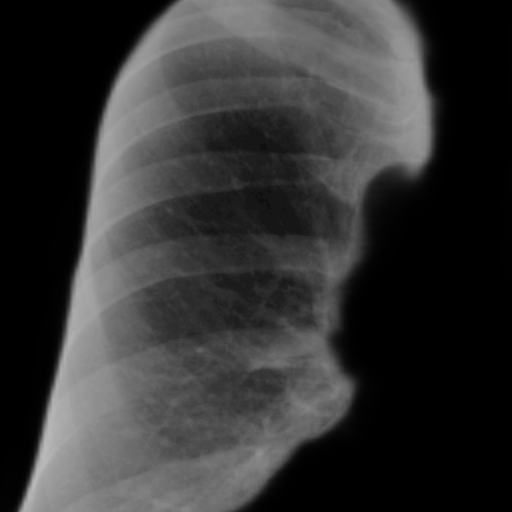

0.0 0.735961458160011 [[1 0 0 0]
 [1 0 0 0]]


In [44]:
x, y = gen[1]
cv2_imshow(x[0]*255.0)
print(np.min(x[0]), np.max(x[0]), y)

In [15]:
from sklearn.metrics import accuracy_score

In [36]:
y = gen.get_y_true()
yhat = np.random.randint(4, 8, size=y.shape)

In [ ]:
y.argmax(axis=1), yhat.argmax(axis=1)

In [38]:
accuracy_score(y.argmax(axis=1), yhat.argmax(axis=1))

0.24719101123595505

#2 Inference

In [48]:
import argparse
from configparser import ConfigParser
import pandas as pd
import os
import cv2
import numpy as np
from utils import normalize, generate_patches, imageNet_preprocessing
from skimage.transform import resize
from models import Resnet18
from sklearn.metrics import confusion_matrix

In [54]:
def generate_patches(img, mask, patch_size = (224, 224), max_patches=100):
    half_patch_size = (int(patch_size[0]/2), int(patch_size[1]/2))
    upper_limit = (img.shape[0] - half_patch_size[0], img.shape[1] - half_patch_size[1])
    lower_limit = half_patch_size

    #select a random 224x224 patch
    patch_array = []
    for i in range(max_patches):    
        while(True):
            x, y = np.random.randint(lower_limit[0], upper_limit[0]), np.random.randint(lower_limit[1], upper_limit[1])
            if(mask[x, y] != 0):
                patch = img[x-half_patch_size[0]:x+half_patch_size[0], y-half_patch_size[1]:y+half_patch_size[1]]
                break
        patch_array.append(patch)
    
    patch_array = np.array(patch_array)

    return patch_array

def imageNet_preprocessing(img):
    if(np.max(img) > 1.0):
        img = img/255.0
    
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    img = (img - means)/ stds
    
    return img

In [59]:
def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("-f", "--file", required=True,
    help="Input file path")

    args = vars(ap.parse_args())

    # parser config
    config_file = "./config.ini"
    cp = ConfigParser()
    cp.read(config_file)

    file = "../splits/Classification/test.csv"
    # base config
    base_dir = cp["BASE"].get("base_dir")
    
    # Seg config
    base_model_name = cp["CLASS"].get("model_name")
    output_weights_name = cp["CLASS"].get("output_weights_name")
    image_dimension = cp["CLASS"].getint("image_dimension")
    
    class_names = cp["CLASS"].get("class_names").split(",") 
    mask_folder = cp["CLASS"].get("mask_folder")  
    patch_size = cp["CLASS"].getint("patch_size")

    output_dir = cp["TEST"].get("output_dir")
    batch_size = cp["TEST"].getint("batch_size")
    N = cp["TEST"].getint("N")
    use_best_weights = cp["TEST"].getboolean("use_best_weights")

    if use_best_weights:
        model_weights_file = os.path.join(output_dir, f"best_{output_weights_name}")    
    else:
        model_weights_file = os.path.join(output_dir, output_weights_name)

    model = Resnet18(
            input_shape=(patch_size, patch_size, 3),
            weights_path=model_weights_file,
            nb_classes=len(class_names))
    
    df = pd.read_csv(file).sample(frac=1.0)

    Y = np.zeros((len(df), ))
    Y_hat = np.zeros((len(df), ))

    for i, [filename, src, y] in enumerate(zip(df['filename'].values, df['image_folder'].values,  df[class_names].astype('int32').values)):
        img = cv2.imread(os.path.join(base_dir, "classification images", filename))
        img = normalize(img, (image_dimension, image_dimension))

        mask = cv2.imread(os.path.join(base_dir, mask_folder, filename), 0)
        mask = resize(mask, (image_dimension, image_dimension))

        img = img *  np.expand_dims(mask, -1)

        patches = generate_patches(img, mask, patch_size=(patch_size, patch_size), max_patches=N)
        #patches = [imageNet_preprocessing(x) for x in patches]
        
        y_hat = np.zeros((len(class_names), ))
        for patch in patches:
            x = np.expand_dims(patch, 0)
            idx = np.argmax(model.predict(x)[0])
            y_hat[idx] +=1

        Y[i] = np.argmax(y)
        Y_hat[i] = np.argmax(y_hat)
        print(y, y_hat)

    print(confusion_matrix(Y, Y_hat))

if __name__ == "__main__":
    main()

load model weights_path: ../experiments/experiment_3/Classification/best_Resnet18_weights.h5
[1 0 0 0] [20.  0.  0.  0.]
[1 0 0 0] [20.  0.  0.  0.]


KeyboardInterrupt: ignored